# Readme
The purpose of this ipynb file is to prepare and fine tune the dataset before training and evaluating several categorical models.

In addition, SHAP analysis will be done for the best peforming model in order to analyse the model's feature importances. This is done for the project's Research Question 2.

- Input: csv file titled 'cleaned'
- Output: NIL 

---

# Content List

1. Importing
2. Read Dataset
3. Encoding
4. Model Training
5. Model Evaluation
6. SHAP Analysis

# 1. Importing

In [ ]:
# Mount google drive for google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Pip install SHAP library
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import relevant general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import io
import os
import os.path
import functools as ft

# Import relevant encoding libraries
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Import relevant modelling libraries
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Import relevant model evaluation libraries
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

# Import SHAP library
import shap

# 2. Read Dataset

In [ ]:
# Check which out of 2 paths is working and set as 'path'
path = '/content/drive/My Drive/{}'
if not os.path.exists(path):
  path = '/content/drive/MyDrive/{}'

# Read in dataset from mounted Google Drive
df = pd.read_csv('{}cleaned.csv'.format(path), index_col=0)

In [ ]:
df.head()

,age,gender,race,marital,education,employment,Academic,Environment,Family,Financial,...,fh_Pervasive and specific developmental disorders,fh_Schizophrenia,fh_Substance-related disorders,cm_Bipolar disorder,cm_Generalized anxiety disorder,cm_Others,cm_Post-traumatic stress disorder,cm_Substance-related disorders,scoring,z_score
person_id,,,,,,,,,,,,,,,,,,,,,
431580018,24,F,White,Single,Educated to high school level,Others,0.0,0.0,-96.0,-5.0,...,1.0,0.0,1.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
431760009,67,F,White,Separated,No formal education,Others,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,12.0,0.0,0.0,0.0,0.0
431940019,54,F,Others,Others,No formal education,Others,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
432010009,26,F,White,Single,No formal education,Others,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,4.0,0.0,0.0,0.0,0.0
432040018,46,F,White,Married,No formal education,Others,0.0,0.0,-2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0


# 3. Encoding

In [ ]:
# Quantile binning for dependant variable
df['binned'] = pd.qcut(df['scoring'], q=4)

In [ ]:
df['binned'].value_counts()

(-0.001, 2.0]     36809
(56.0, 2074.0]    27922
(10.0, 56.0]      26312
(2.0, 10.0]       20803
Name: binned, dtype: int64

In [ ]:
# Ordinal encoding for dependent variable
ord_enc = OrdinalEncoder()
df["binned_encoded"] = ord_enc.fit_transform(df[["binned"]])

# Check count distribution of each bin
df['binned_encoded'].value_counts()

0.0    36809
3.0    27922
2.0    26312
1.0    20803
Name: binned_encoded, dtype: int64

In [ ]:
# Create new 'df_encoded' with only encoded dependant variables, 
# scaled stressor columns and dummies of demographic columns.
df_encoded = pd.get_dummies(
    df.drop(columns=['z_score','scoring','binned']),
    columns=['employment','gender','race','marital','education'], 
    drop_first=True
)

In [ ]:
# Fill all NaN values with 0
df_encoded.fillna(0,inplace=True)

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111846 entries, 431580018 to 119140025
Data columns (total 40 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   age                                                111846 non-null  float64
 1   Academic                                           111846 non-null  float64
 2   Environment                                        111846 non-null  float64
 3   Family                                             111846 non-null  float64
 4   Financial                                          111846 non-null  float64
 5   Housing                                            111846 non-null  float64
 6   Legal                                              111846 non-null  float64
 7   Occupational                                       111846 non-null  float64
 8   Social                                             111846 non-n

# 4. Model Training

In [ ]:
# Split df_encoded into dfs with independent and dependent variables
df_y = df_encoded['binned_encoded']
df_x = df_encoded.drop(columns = ['binned_encoded'])

In [ ]:
# Stratified train test splits 
X_train, X_test, y_train, y_test = train_test_split(df_x,df_y, test_size=0.1, stratify=df_encoded['binned_encoded'])

In [ ]:
#oversampling with SMOTE
print("Before oversampling: ",Counter(y_train))

# define oversampling strategy
SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

Before oversampling:  Counter({0.0: 33128, 3.0: 25130, 2.0: 23681, 1.0: 18722})
After oversampling:  Counter({1.0: 33128, 3.0: 33128, 2.0: 33128, 0.0: 33128})


Model Tuning

In [ ]:
# #grid search
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }

# grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv= 5)
# grid.fit(X_train_SMOTE, y_train_SMOTE)
# print(grid.best_params_) 
# grid_pred=grid.predict(X_test)
# score = f1_score(y_test, grid_pred, average="weighted")
# print("Random Forest F1-Score: ", score)
# grid_proba_tuned = grid.predict_proba(X_test)
# score = roc_auc_score(y_test, grid_proba_tuned, average="weighted", multi_class='ovr')
# print("Random Forest AUROC: ", score)

In [ ]:
# #grid search
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C': [0.1, 1, 2, 5, 10, 20, 50],  
#               'penalty': ["l1","l2","elasticnet"], 
#               'solver':['lbfgs', 'sag', 'saga' , 'newton-cg'],
#               'multi_class': ['multinomial','ovr']} 
# grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
# # fitting the model for grid search 
# grid.fit(X_train_SMOTE, y_train_SMOTE)  
# print(grid.best_params_) 
# grid_pred=grid.predict(X_test)
# score = f1_score(y_test, grid_pred, average="weighted")
# print("Logistic Regression F1-Score: ", score)
# grid_proba_tuned = grid.predict_proba(X_test)
# score = roc_auc_score(y_test, grid_proba_tuned, average="weighted", multi_class='ovr')
# print("Log Reg AUROC: ", score)

In [ ]:
# #single model test
# from sklearn.metrics import f1_score
# from sklearn.metrics import roc_auc_score
# model_tuned=RandomForestClassifier()
# # model_tuned=LogisticRegression(C=5, penalty='l2',solver='saga',multi_class='multinomial',max_iter=10000)
# model_tuned.fit(X_train_SMOTE, y_train_SMOTE)
# labels_tuned = model_tuned.predict(X_test)
# score = f1_score(y_test, labels_tuned, average="weighted")
# print("Logistic Regression F1-Score: ", score)
# labels_proba_tuned = model_tuned.predict_proba(X_test)
# score = roc_auc_score(y_test, labels_proba_tuned, average="weighted", multi_class='ovr')
# print("Log Reg AUROC: ", score)

In [ ]:
# Call and fit models on train df sets

# Model & label 1 for Decision Tree classifier
model_1 = tree.DecisionTreeClassifier()
model_1.fit(X_train_SMOTE, y_train_SMOTE)
labels_1 = model_1.predict(X_test)
labels_proba_1 = model_1.predict_proba(X_test)

# Model & label 2 for KNN classifier
model_2 = KNeighborsClassifier()
model_2.fit(X_train_SMOTE, y_train_SMOTE)
labels_2 = model_2.predict(X_test)
labels_proba_2 = model_2.predict_proba(X_test)

# Model & label 3 for Random Forest classifier
model_3 = RandomForestClassifier()
model_3.fit(X_train_SMOTE, y_train_SMOTE)
labels_3 = model_3.predict(X_test)
labels_proba_3 = model_3.predict_proba(X_test)

# Model & label 4 for Logistic Regression classifier with optimum hyperparameters
model_4 = LogisticRegression(C=10, penalty='l1',solver='saga',multi_class='multinomial',max_iter=10000)
model_4.fit(X_train_SMOTE, y_train_SMOTE)
labels_4 = model_4.predict(X_test)
labels_proba_4 = model_4.predict_proba(X_test)

# Model & label 5 for Random Forest classifier with optimum hyperparameters
model_5 = RandomForestClassifier(criterion= 'gini', max_depth= 8, max_features= 'auto', n_estimators= 200)
model_5.fit(X_train_SMOTE, y_train_SMOTE)
labels_5 = model_5.predict(X_test)
labels_proba_5 = model_5.predict_proba(X_test)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


# 5. Model Evaluation

In [ ]:
# Calculate F1 score for each model
score = f1_score(y_test, labels_1, average="weighted")
print("Decision Tree F1-Score: ", score)
score = f1_score(y_test, labels_2, average="weighted")
print("KNN F1-Score: ", score)
score = f1_score(y_test, labels_3, average="weighted")
print("Random Forest F1-Score: ", score)
score = f1_score(y_test, labels_4, average="weighted")
print("Logistic Regression Tuned F1-Score: ", score)
score = f1_score(y_test, labels_5, average="weighted")
print("Random Forest Tuned F1-Score: ", score)

Decision Tree F1-Score:  0.45694972676072504
KNN F1-Score:  0.4393670828101107
Random Forest F1-Score:  0.5135005698225933
Logistic Regression Tuned F1-Score:  0.5150164668381777
Random Forest Tuned F1-Score:  0.5253551413329653


In [ ]:
# Calculate AUROC for each model
score = roc_auc_score(y_test, labels_proba_1, average="weighted", multi_class='ovr')
print("Decision Tree AUROC: ", score)
score = roc_auc_score(y_test, labels_proba_2, average="weighted", multi_class='ovr')
print("KNN AUROC: ", score)
score = roc_auc_score(y_test, labels_proba_3, average="weighted", multi_class='ovr')
print("Random Forest AUROC: ", score)
score = roc_auc_score(y_test, labels_proba_4, average="weighted", multi_class='ovr')
print("Logistic Regression Tuned AUROC: ", score)
score = roc_auc_score(y_test, labels_proba_5, average="weighted", multi_class='ovr')
print("Random Forest Tuned AUROC: ", score)

Decision Tree AUROC:  0.6366366812427097
KNN AUROC:  0.6759444677122425
Random Forest AUROC:  0.7648197973466866
Logistic Regression Tuned AUROC:  0.7704375566863939
Random Forest Tuned AUROC:  0.7816077247877836


In [ ]:
# Calculate AUROC for each model
score = log_loss(y_test, labels_proba_1)
print("Decision Tree Log Loss: ", score)
score = log_loss(y_test, labels_proba_2)
print("KNN Log Loss: ", score)
score = log_loss(y_test, labels_proba_3)
print("Random Forest Log Loss: ", score)
score = log_loss(y_test, labels_proba_4)
print("Logistic Regression Tuned Log Loss: ", score)
score = log_loss(y_test, labels_proba_5)
print("Random Forest Tuned Log Loss: ", score)

Decision Tree Log Loss:  18.73533402735696
KNN Log Loss:  8.468539710358073
Random Forest Log Loss:  1.5458984857447198
Logistic Regression Tuned Log Loss:  1.0676730465377435
Random Forest Tuned Log Loss:  1.0716781239459208


              precision    recall  f1-score   support

         0.0       0.54      0.69      0.61      3681
         1.0       0.30      0.29      0.30      2081
         2.0       0.43      0.38      0.40      2631
         3.0       0.81      0.62      0.71      2792

    accuracy                           0.53     11185
   macro avg       0.52      0.50      0.50     11185
weighted avg       0.54      0.53      0.53     11185



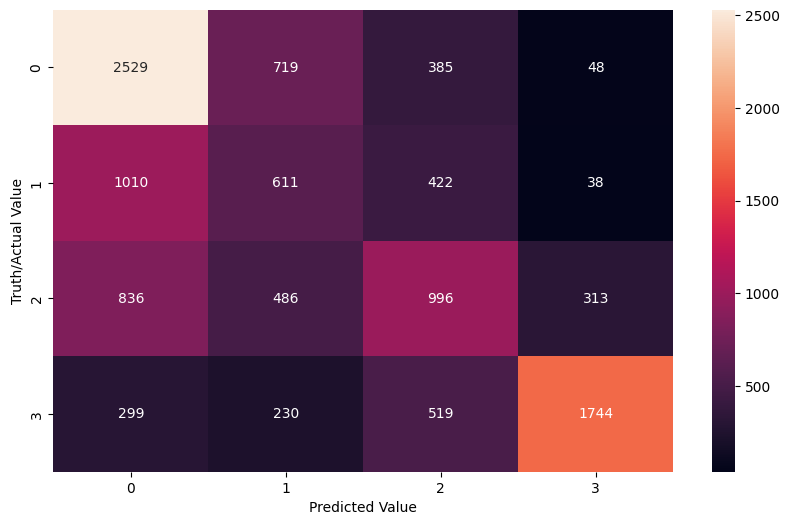

In [ ]:
# Confusion matrix of Random Forest Tuned on test data
cm = confusion_matrix(y_test, labels_5) 
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True,fmt='g')
plt.xlabel('Predicted Value') 
plt.ylabel('Truth/Actual Value')

# Print classification report for model on actual results
print(classification_report(y_test, labels_5))

# 6. SHAP Analysis

In [ ]:
# SHAP analysis for Random Forest Tuned
explainer_5 = shap.Explainer(model_5.predict, X_train_SMOTE)
shap_values_5 = explainer_5(X_test)

Permutation explainer: 11186it [2:32:38,  1.22it/s]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


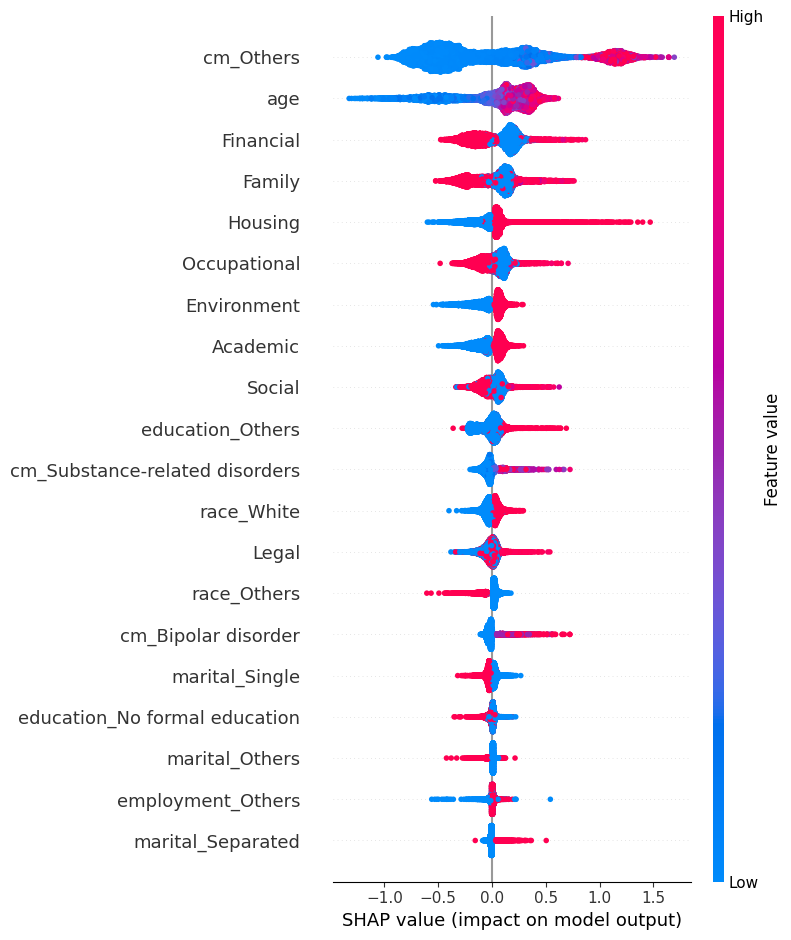

In [ ]:
# SHAP Summary plot for Random Forest Tuned
shap.summary_plot(shap_values_5)